# Project

---

# Import Libraries & Declare paths

In [4]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  print("No-drive")

# We install the Simple Transformers library to use Transformer models in a simple way
# !pip install simpletransformers
import pandas as pd
import numpy as np
import os
import time
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import nltk
import pickle
nltk.download('names')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import names
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import torch
import random
import os
import torch
import re
from sklearn.model_selection import train_test_split
import pandas as pd
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.simplefilter("ignore")

device = torch.device("cuda")
device

No-drive


[nltk_data] Downloading package names to
[nltk_data]     C:\Users\matti\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\matti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\matti\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


device(type='cuda')

---
# Data Extraction
---

In [5]:
path_model="model/"
path_data="data/"

df_sentence = pd.read_csv(path_data+"dataset_topics_GA_10000.csv",  sep=";;;;", encoding="utf-8")
print("La dimensione del dataset è la seguente: ",len(df_sentence))

#imposta la variabile a True per ridurre i testi a desiderati=X ai fini di Test, dove X è la size del tuo Dataset finale
riduci_X_test=False
if riduci_X_test==True:
    random.seed(42)
    desiderati=1000
    size_remove=len(df_sentence)-desiderati
    elenco = set()
    while len(elenco)<size_remove:
        n = random.randint(0, (len(df_sentence)-1))
        elenco.add(n)
    print(len(elenco))
    df_sentence.drop(index=elenco, inplace=True)
    df_sentence.reset_index(inplace=True)
    print(len(df_sentence))

df_sentence.head(2)

La dimensione del dataset è la seguente:  165991


,Id,FactAndLaw,Topics
0,ga-tar_cz-2021-3-1,"-OMISSIS-, Luogotenente dell&rsquo;Arma dei Ca...","""[""""Procedimento amministrativo""""]"""
1,ga-tar_fi-2021-3-1,La ricorrente agisce per ottenere l&rsquo;acce...,"""[""""Sospensione Concessione""""]"""


---
# Data analysis
---

In [6]:
df=df_sentence.copy()
df_without_duplicates = df.drop_duplicates()
df_without_duplicates.reset_index(drop=True,inplace=True)
print("La dimensione del dataset è la seguente: ",len(df_without_duplicates))
df_without_duplicates.head(2)['FactAndLaw'][0]

La dimensione del dataset è la seguente:  164271


"-OMISSIS-, Luogotenente dell&rsquo;Arma dei Carabinieri, ha impugnato con richiesta di sospensione, la sanzione di stato della &ldquo;sospensione disciplinare dall&rsquo;impiego&rdquo; per mesi 8 comminata per avere il militare ricevuto avviso di garanzia per concorso in estorsione con metodo mafioso per omesso intervento in appurata vicenda estorsiva a danno di imprenditore. A sostegno del ricorso ha lamentato la violazione dell&rsquo;art. 1393, secondo e terzo capoverso, del C.O.M in quanto la fattispecie andrebbe sussunta nella residuata ipotesi di pregiudiziale penale, la violazione dei termini del procedimento disciplinare, l&rsquo;eccesso di potere per difetto di istruttoria e la violazione del principio di proporzionalit&agrave;. Ha, altres&igrave; domandato il risarcimento del danno di natura patrimoniale conseguente alla sanzione per la derivata riduzione dello stipendio, per le conseguenze sullo stato di servizio e pensionistico e di natura non patrimoniale per il danno all&

In [8]:
def clear_topics(x):
    chars = '"[];\\\r\\\n\\'
    return x.translate(str.maketrans('', '', chars))
df_without_duplicates['Topics']=df_without_duplicates['Topics'].apply(clear_topics)
df_without_duplicates=df_without_duplicates.dropna( subset=['FactAndLaw']).reset_index(drop=True)
print(df_without_duplicates.isna().sum())

Id            0
FactAndLaw    0
Topics        0
dtype: int64


---
# Data_Visualization
---

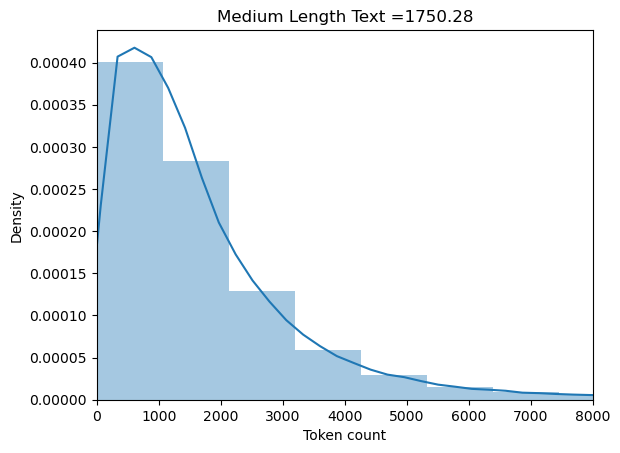

In [9]:
def plot_token_occ(x,start,end, genere,title):
    token_lens = []
    for txt in x:
        txt_l=(str(txt)).split(' ')
        token_lens.append(len(txt_l))
    media=np.mean(token_lens)
    sns.distplot(token_lens)
    plt.xlim([start,end])
    plt.xlabel('Token count')
    plt.title(title+genere+" ="+ str(round(media,2)))
    plt.show()

df=pd.DataFrame(df_without_duplicates['FactAndLaw'])
plot_token_occ(df['FactAndLaw'].tolist(),0,8000,'','Medium Length Text')

---
# Data Preparation
---

In [10]:
def preprocessing(ds,print_val=1000,first=0,end=len(df)):
    New_Testo = []
    occ=0
    occ_print=print_val
    start_time = time.time()

    with open(path_data+"exception/"+"comuni.txt", "r") as tf:
        comuni = tf.read().split('\n')
    comuni=set(list(x.lower() for x in comuni))
    with open(path_data+"exception/"+"otherStopwords.txt", "r") as tfo:
        otherstopwords = tfo.read().split('\n')
    otherstopwords=set(list(x.lower() for x in otherstopwords))
    with open(path_data+"exception/"+"avverbi_italiani.txt", "r") as tfo:
        avverbi_italiani = tfo.read().split('\n')
    avverbi_italiani=set(list(x.lower() for x in avverbi_italiani))
    with open(path_data+"exception/"+"acronimi_.txt", "r") as tfo:
        acronimi = tfo.read().split('\n')
    acronimi=list(x.lower() for x in acronimi)
    acronimi=set(list(''.join(filter(lambda x: x not in ['.',' ',',','-','!','?','#','\\','/','^','\'','\s','\n','\t'], w)) for w in acronimi))
    with open(path_data+"exception/"+"codifiche_accenti.txt", "r") as tfo:
        codifiche_accenti = tfo.read().split('\n')
    codifiche_accenti=set(list(x.lower() for x in codifiche_accenti))

    for _,_,files in os.walk(path_data+"exception/"):
        for file in files:
            if not file in ['acronimi_.txt','avverbi_italiani.txt','codifiche_accenti.txt','comuni.txt','otherStopwords.txt']: 
                print(f"Ci troviamo nella cartella: '{file}'")
                with open(path_data+"exception/"+file, "r") as tfo:
                    otherstopwords_plus = tfo.read().split('\n')
                otherstopwords=set(list(otherstopwords+otherstopwords_plus))
    print('Analizzare i testi dalla riga:',first,', alla riga:',end)

    # stopwords list
    stop_words = set(stopwords.words('italian'))
    stemmer = SnowballStemmer("italian")
    nomi_person= set(w.lower() for w in names.words('male.txt')+names.words('female.txt'))

    eccezioni=set(comuni.union(stop_words.union(codifiche_accenti.union(otherstopwords.union(nomi_person.union(avverbi_italiani.union(acronimi)))))))

    
    for ind in range (first,end):
        #LOWER_CASE
        testo= str(ds[ind]).lower()

        # tokenization
        word_tokens = nltk.word_tokenize(testo);

        # Rimuovi punteggiatura
        word_tokens = list(filter(lambda token: token not in string.punctuation, word_tokens))

        # stoppping and stemming
        filtered_sentence = [re.sub(r'[0-9]+', '',stemmer.stem(''.join(filter(lambda x: x not in ['.',' ',',','-','!','?','#','\\','/','^','\'','\s','\n','\t'], w)))) 
                            for w in word_tokens if (not w in eccezioni) 
                            and (len(stemmer.stem(w))>3) ]
        filtered_sentence= [w for w in filtered_sentence if (not w in eccezioni) and (len(w)>3)]

        document = ' '.join(filtered_sentence)
        # sostituisci risultato:
        New_Testo.append(document)
        end_time = time.time()
        t = time.strftime("%Hh:%Mm:%Ss",time.gmtime(int(end_time)-int(start_time)))
        if (occ%occ_print==0 and occ!=0) or (occ==(len(ds)-1)):
            print('analizzati',occ,'record',",tempo impiegato per trasformare",occ_print,"file: "+t,'size del vettore:',len(New_Testo)-1)
            start_time = time.time()
        occ+=1
    return New_Testo

def index_download(indice_path):
    ind=0
    if not Path(indice_path).exists():
        f= open(indice_path, "w")
        f.write(str(0))
        f.close()
    f=open(indice_path,"r")
    ind=int(f.read())
    f.close()
    return int(ind)

def carica_text(indice,path_d):
    if not Path(path_d).exists():
        print('Creato file di checkpoint per il nostro array dei testi processati')
        with open(path_d, 'w') as temp:
            primo=preprocessing(testi,10,indice,indice+1)
            pp=pd.DataFrame(primo, columns = ['FactAndLaw'])
            pp.to_csv(temp, index=False)
            indice+=1
    with open (path_d, 'r') as temp:
        processed_text = pd.read_csv(temp)
    return processed_text,indice

def salva_text(indice,testi, indice_path, path_d):
    with open(indice_path, 'w') as temp:
        temp.truncate(0)
        temp.write(str(indice))
        temp.close()

    with open(path_d, 'w') as temp:
        testi.to_csv(temp, index=False)
    return testi

def preprocessing_col(testi, indice_path,path_d):
    print('I record in totale sono:',len(testi))
    indice=index_download(indice_path)
    print("L'ultimo checkpoit è stato al record:",indice)

    text_loaded,indice=carica_text(indice,path_d)

    intervall=5

    stampa_ogni=(len(df))//intervall
    end_ds=indice+(stampa_ogni*intervall)
    # step_NO
    # end_ds=end_ds//4
    stampa_ogni=stampa_ogni//10
    processed_text_final=text_loaded
    if indice==1:
        end_ds-=1
    if end_ds>len(testi):
        end_ds=len(testi)
    if indice!=len(testi):
        new_text_processed=pd.DataFrame( preprocessing(testi,stampa_ogni,indice,end_ds),columns = ['FactAndLaw'])
        processed_text=pd.DataFrame.append(text_loaded,new_text_processed)
        processed_text_final=salva_text(end_ds,processed_text,indice_path,path_d)

    return processed_text_final


testi=df['FactAndLaw'].copy().tolist()

start_time = time.time()
processed_sentence_final=preprocessing_col(testi,path_data+"index_scan_sentence.txt",path_data+'outputfile_sentence_processed.csv')
end_time = time.time()
t = time.strftime("%Hh:%Mm:%Ss",time.gmtime(int(end_time)-int(start_time)))
print("Tempo totale impiegato per la trasformazione dei files: "+t)

print(processed_sentence_final.info())
len(processed_sentence_final)
processed_sentence_final.head(2)

I record in totale sono: 164271
L'ultimo checkpoit è stato al record: 164271
Tempo totale impiegato per la trasformazione dei files: 00h:00m:09s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164271 entries, 0 to 164270
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   FactAndLaw  164271 non-null  object
dtypes: object(1)
memory usage: 1.3+ MB
None


,FactAndLaw
0,luogotenent arma carabinier impugn richiest so...
1,ricorrent agisc otten access document inerent ...


---
## Preparation final Dataset
---

In [11]:
Data_Set=pd.DataFrame({'text':list(processed_sentence_final['FactAndLaw'])})
Data_Set.head(2)

,text
0,luogotenent arma carabinier impugn richiest so...
1,ricorrent agisc otten access document inerent ...


---
## Tif idf vectorizer
---

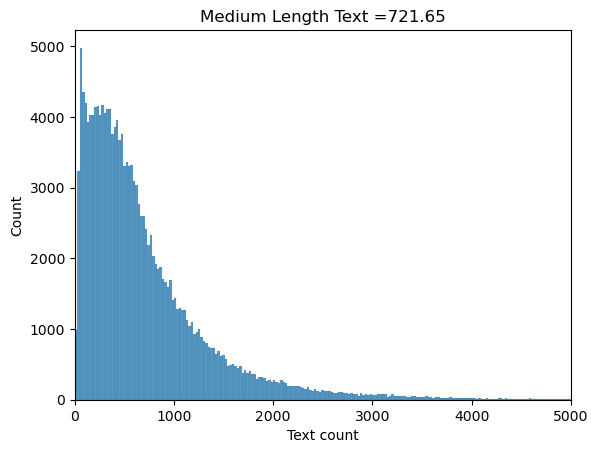

In [13]:
def plot_token_occ(x,start,end, genere,title):
    token_lens = []
    for txt in x:
        txt_l=(str(txt)).split(' ')
        token_lens.append(len(txt_l))
    media=np.mean(token_lens)
    sns.histplot(token_lens)
    plt.xlim([start,end])
    plt.xlabel('Text count')
    plt.title(title+genere+" ="+ str(round(media,2)))
    plt.show()

plot_token_occ(Data_Set['text'].tolist(),0,5000,'','Medium Length Text')

In [14]:
def time_calculate(bool_t=True,start_time=0):
    if bool_t==True:
        print('START: ',datetime.today().strftime('%Y-%m-%d %H:%M'))
        return time.time()
    else:
        end_time=time.time()
        print('END: ',datetime.today().strftime('%Y-%m-%d %H:%M'))
        giorno_in_sec=86400
        giorni=(int(end_time)-int(start_time))//giorno_in_sec
        t = time.strftime("%Hh:%Mm:%Ss",time.gmtime(int(end_time)-int(start_time)))
        print("tempo impiegato "+str(giorni)+'d:'+t)
        return t
    
# prima splitta in train test
X = Data_Set[['text']]
X_train, X_test=train_test_split(X,test_size=0.10, random_state=42)
print('Size train ds:',len(X))
print('Size iniziale dei record:',len(list(Data_Set['text'])),'\nSize train ds:',len(X_train),'\nSize test ds:',len(X_test))

Size train ds: 164271
Size iniziale dei record: 164271 
Size train ds: 147843 
Size test ds: 16428


In [15]:
X_train['text']

90432     appell esam odiern appell impugn sentenz respi...
162299    ricors notific deposit termin ricorrent premes...
148198    epigraf questur provinc indirizz filipp achill...
51426     chied annull epigraf indic diffid rimuov inseg...
139997    ricorrent otten rilasc permess soggiorn validi...
                                ...                        
119879    difes amministr deposit giudiz uffic immigr qu...
103694    societ ricorrent impugn comunic esclus procedu...
131932    ricorrent titol armi venator decret ottobr not...
146867    ricors epigraf ricorrent chied annull decret s...
121958    impugn questor rigett cittadin niger ricorrent...
Name: text, Length: 147843, dtype: object

In [16]:
print("Tf-idf")
# tfizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.80)
tfizer = TfidfVectorizer(
                          ngram_range=(1,2),
                          lowercase=True,
                          sublinear_tf=True,
                          max_features=10000,
                          tokenizer=None,
                          preprocessor=None,
                          dtype=np.float32,
                          max_df=0.80,
                          min_df=5
                          )

start_time=time_calculate()
print("tfidf.pickle")
if os.path.isfile(path_model+"tfidf.pickle"):
  with open(path_model+"tfidf.pickle", "rb") as f:           # riapre il file in lettura ...
    tfizer=pickle.load(f)                                  # ... carica il record ...
    X_tfidf=tfizer.transform(X_train['text'])
    f.close()
else:
  with open(path_model+"tfidf.pickle", "wb") as f:           # riapre il file in scrittura ...
    X_tfidf =  tfizer.fit_transform(X_train['text'])
    pickle.dump(tfizer,f)                                  # ... salva il record ...
    f.close()

X_tfidf_test = tfizer.transform(X_test['text'])
end_time=time_calculate(bool_t=False,start_time=start_time)

print('Size vettore_ds:',X_tfidf.shape,
      '\nSize test vettore_ds:',X_tfidf_test.shape)

Tf-idf
START:  2023-10-12 23:56
tfidf.pickle
END:  2023-10-12 23:59
tempo impiegato 0d:00h:03m:08s
Size vettore_ds: (147843, 10000) 
Size test vettore_ds: (16428, 10000)


---
# Data Model
---

In [20]:
def train_clustering(f,model):
    start_time=time_calculate()

    if os.path.isfile(f):
        kmeans = pickle.load(open(f, 'rb'))
        print("MODELLO GIA' ADDESTRATO")
    else:
        print('TRAINING MODEL')
        kmeans = model
        kmeans.fit(X_tfidf);
        print("MODELLO ADDESTRATO")
        pickle.dump(kmeans, open(f, 'wb'))

    end_time=time_calculate(bool_t=False,start_time=start_time)

    clusters = kmeans.labels_
    return kmeans,clusters

def get_top_keywords(n_terms, vectorizer=tfizer, clusters=0):
    """Questa funzione restituisce le keyword per ogni centroide del KMeans"""
    df = pd.DataFrame(X_tfidf.todense()).groupby(clusters).mean() # raggruppa il vettore TF-IDF per gruppo
    terms = vectorizer.get_feature_names_out() # accedi ai termini del tf idf
    ris=[]
    ris_f=[]
    for i,r in df.iterrows():
        # print('\nCluster {}'.format(i))
        # print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # per ogni riga del dataframe, trova gli n termini che hanno il punteggio più alto
        ris.append((str(','.join([terms[t] for t in np.argsort(r)[-n_terms:]]))))
    for i in ris:
      ris_f.append(i.split(','))
    return ris_f

---
## CLUSTERING
---

### K-Means Elbow Method
---
determinare il numero corretto di cluster


START:  2023-10-13 00:00
MODELLO GIA' ADDESTRATO
END:  2023-10-13 00:00
tempo impiegato 0d:00h:00m:00s
START:  2023-10-13 00:00
MODELLO GIA' ADDESTRATO
END:  2023-10-13 00:00
tempo impiegato 0d:00h:00m:00s
START:  2023-10-13 00:00
MODELLO GIA' ADDESTRATO
END:  2023-10-13 00:00
tempo impiegato 0d:00h:00m:00s
START:  2023-10-13 00:00
MODELLO GIA' ADDESTRATO
END:  2023-10-13 00:00
tempo impiegato 0d:00h:00m:00s
START:  2023-10-13 00:00
MODELLO GIA' ADDESTRATO
END:  2023-10-13 00:00
tempo impiegato 0d:00h:00m:00s
START:  2023-10-13 00:00
MODELLO GIA' ADDESTRATO
END:  2023-10-13 00:00
tempo impiegato 0d:00h:00m:00s
START:  2023-10-13 00:00
MODELLO GIA' ADDESTRATO
END:  2023-10-13 00:00
tempo impiegato 0d:00h:00m:00s
START:  2023-10-13 00:00
MODELLO GIA' ADDESTRATO
END:  2023-10-13 00:00
tempo impiegato 0d:00h:00m:00s
START:  2023-10-13 00:00
MODELLO GIA' ADDESTRATO
END:  2023-10-13 00:00
tempo impiegato 0d:00h:00m:00s
START:  2023-10-13 00:00
MODELLO GIA' ADDESTRATO
END:  2023-10-13 00:00
t

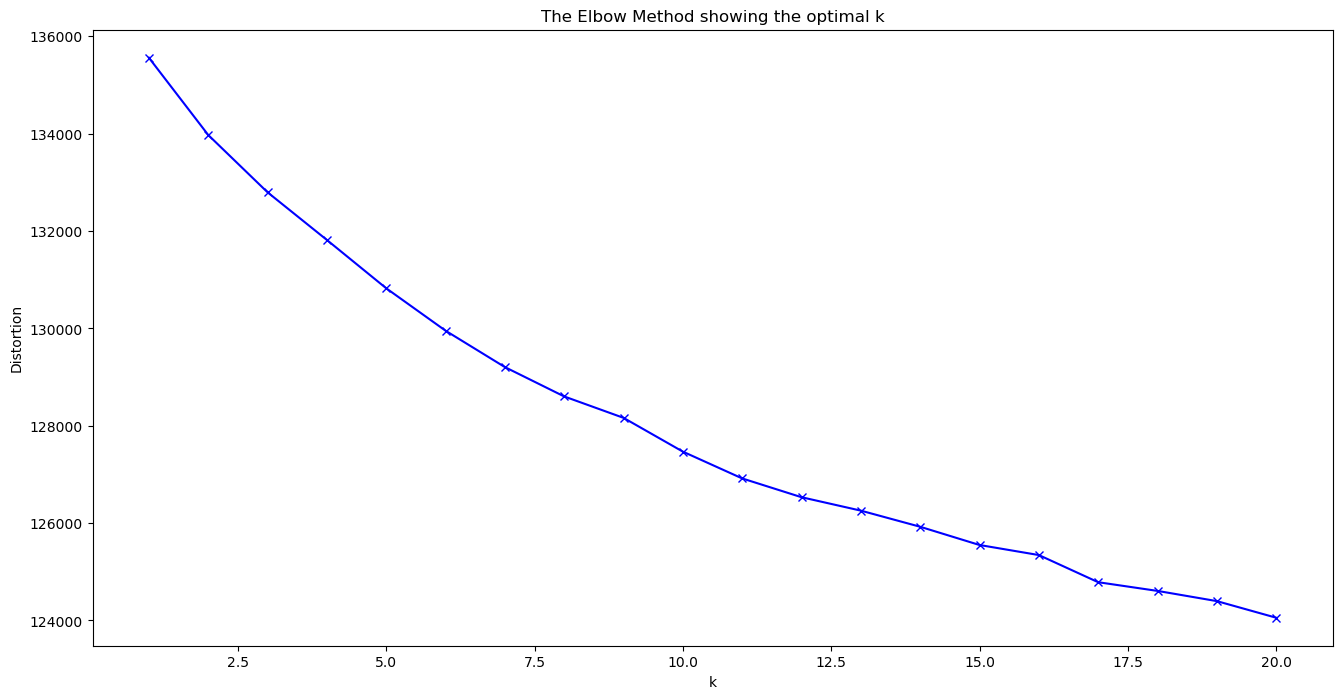

In [21]:
path_k_means=path_model+"k-means/"
distortions = []
K = range(1,21)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    f = path_k_means+"K_means_"+ str(k)
    kmeans,clusters=train_clustering(f,kmeans)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

---
### Model K-means
---

In [22]:
path_k_means=path_model+"k-means/"

n_cluster=5
kmeans = KMeans(n_clusters=n_cluster, random_state=42)

f = path_k_means+"K_means_"+ str(n_cluster)

kmeans,clusters=train_clustering(f,kmeans)

START:  2023-10-13 00:00
MODELLO GIA' ADDESTRATO
END:  2023-10-13 00:00
tempo impiegato 0d:00h:00m:00s


---
#### Riduzione della dimensionalità e visualizzazione
---

In [23]:
start_time=time_calculate()

# inizializziamo la PCA con 2 componenti
pca = PCA(n_components=2, random_state=42)
if os.path.isfile(path_model+"pca.pickle"):
  with open(path_model+"pca.pickle", "rb") as f:           # riapre il file in lettura ...
    pca=pickle.load(f)                                     # ... carica il record ...
    pca_vecs = pca.transform(X_tfidf.toarray())
    f.close()
else:
  with open(path_model+"pca.pickle", "wb") as f:           # riapre il file in lettura ...
    # passiamo alla pca il nostro array X
    pca_vecs = pca.fit_transform(X_tfidf.toarray())
    pickle.dump(pca,f)                                     # ... salva il record ...
    f.close()

# salviamo le nostre due dimensioni in x0 e x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

end_time=time_calculate(bool_t=False,start_time=start_time)

X_train['cluster'] = clusters
X_train['x0'] = x0
X_train['x1'] = x1
X_train

START:  2023-10-13 00:00
END:  2023-10-13 00:02
tempo impiegato 0d:00h:01m:50s


,text,cluster,x0,x1
90432,appell esam odiern appell impugn sentenz respi...,4,0.159567,0.013045
162299,ricors notific deposit termin ricorrent premes...,4,0.080725,-0.034025
148198,epigraf questur provinc indirizz filipp achill...,4,-0.075054,-0.106010
51426,chied annull epigraf indic diffid rimuov inseg...,4,0.068130,0.000678
139997,ricorrent otten rilasc permess soggiorn validi...,3,-0.145448,-0.227865
...,...,...,...,...
119879,difes amministr deposit giudiz uffic immigr qu...,3,-0.192645,-0.180557
103694,societ ricorrent impugn comunic esclus procedu...,0,0.179495,0.068008
131932,ricorrent titol armi venator decret ottobr not...,4,-0.042118,-0.104065
146867,ricors epigraf ricorrent chied annull decret s...,3,-0.124497,-0.211913


In [24]:
n_cluster_key=100
terms=get_top_keywords(n_cluster_key,tfizer, clusters)

a = np.array(terms)

np.savetxt(path_data+'word-cluster.txt', a, delimiter=",", newline = "]\n\nclusterX=\n[", fmt="%s")


In [25]:
n_cluster_key=10
terms=get_top_keywords(n_cluster_key,tfizer, clusters)

Cluser_topmeansKey=["Cluster "+str(i) for i in (range(n_cluster))]

with open(path_model+"cluster_map.pickle"+str(n_cluster_key), "wb") as f:           # riapre il file in lettura ...
  # mappiamo cluster con termini adatti
  cluster_map={}
  for i in range(0,n_cluster):
    cluster_map[i]=",".join(j for j in terms[i])
    cluster_map[i]=Cluser_topmeansKey[i]+" = ["+cluster_map[i]+"]"
  pickle.dump(cluster_map,f)                                     # ... salva il record ...
  f.close()

# applichiamo mappatura
X_train['cluster'] = X_train['cluster'].map(cluster_map)
X_train

,text,cluster,x0,x1
90432,appell esam odiern appell impugn sentenz respi...,"Cluster 4 = [relat,risult,motiv,sens,interess,...",0.159567,0.013045
162299,ricors notific deposit termin ricorrent premes...,"Cluster 4 = [relat,risult,motiv,sens,interess,...",0.080725,-0.034025
148198,epigraf questur provinc indirizz filipp achill...,"Cluster 4 = [relat,risult,motiv,sens,interess,...",-0.075054,-0.106010
51426,chied annull epigraf indic diffid rimuov inseg...,"Cluster 4 = [relat,risult,motiv,sens,interess,...",0.068130,0.000678
139997,ricorrent otten rilasc permess soggiorn validi...,"Cluster 3 = [rilasc,redd,rinnov,rinnov permess...",-0.145448,-0.227865
...,...,...,...,...
119879,difes amministr deposit giudiz uffic immigr qu...,"Cluster 3 = [rilasc,redd,rinnov,rinnov permess...",-0.192645,-0.180557
103694,societ ricorrent impugn comunic esclus procedu...,"Cluster 0 = [procedur,esclusion,tecnic,concorr...",0.179495,0.068008
131932,ricorrent titol armi venator decret ottobr not...,"Cluster 4 = [relat,risult,motiv,sens,interess,...",-0.042118,-0.104065
146867,ricors epigraf ricorrent chied annull decret s...,"Cluster 3 = [rilasc,redd,rinnov,rinnov permess...",-0.124497,-0.211913


---
### Plotting
---

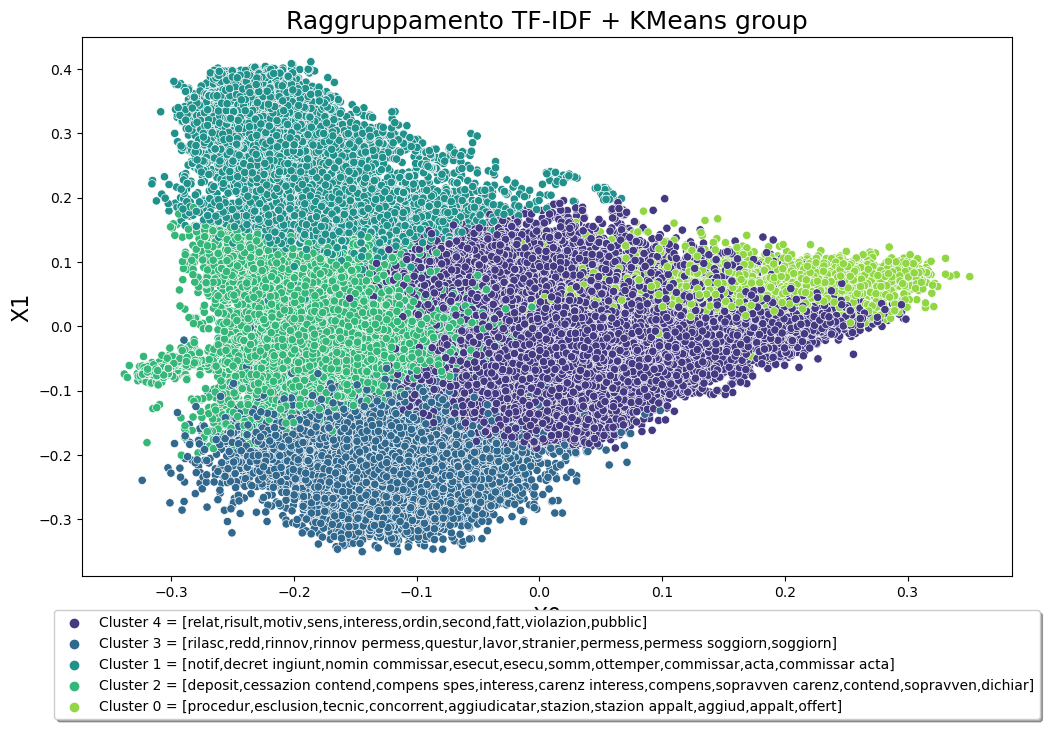

In [26]:
def plot_cluster(X_train,title):
  # settiamo la grandezza dell'immagine
  plt.figure(figsize=(12, 7))
  # settiamo titolo
  plt.title(title, fontdict={"fontsize": 18})
  # settiamo nome assi
  plt.xlabel("X0", fontdict={"fontsize": 16})
  plt.ylabel("X1", fontdict={"fontsize": 16})
  # creiamo diagramma a dispersione con seaborn, dove hue è la classe usata per raggruppare i dati
  sns.scatterplot(data=X_train, x='x0', y='x1', hue='cluster', palette="viridis")
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True)
  # plt.savefig('PLOT/Raggruppamento TF-IDF kmeans '+str(n_cluster)+' cluster.png')
  plt.show()
plot_cluster(X_train,title="Raggruppamento TF-IDF + KMeans group")

---
# PREDICTION TEST
---

In [27]:
pca_vecs_test = pca.transform(X_tfidf_test.toarray())
# salviamo le nostre due dimensioni in x0 e x1
x0_test = pca_vecs_test[:, 0]
x1_test = pca_vecs_test[:, 1]

start_time=time_calculate()
X_test['cluster'] = kmeans.predict(X_tfidf_test)
X_test['cluster'] = X_test['cluster'].map(cluster_map)
end_time=time_calculate(bool_t=False,start_time=start_time)

X_test['x0'] = x0_test
X_test['x1'] = x1_test
X_test.head(2)

START:  2023-10-13 00:03
END:  2023-10-13 00:03
tempo impiegato 0d:00h:00m:01s


,text,cluster,x0,x1
57559,appell esam odiern appell impugn sentenz riget...,"Cluster 4 = [relat,risult,motiv,sens,interess,...",-0.036373,-0.029012
131789,raccomand individu seguent serviz access detta...,"Cluster 4 = [relat,risult,motiv,sens,interess,...",0.226724,0.030582


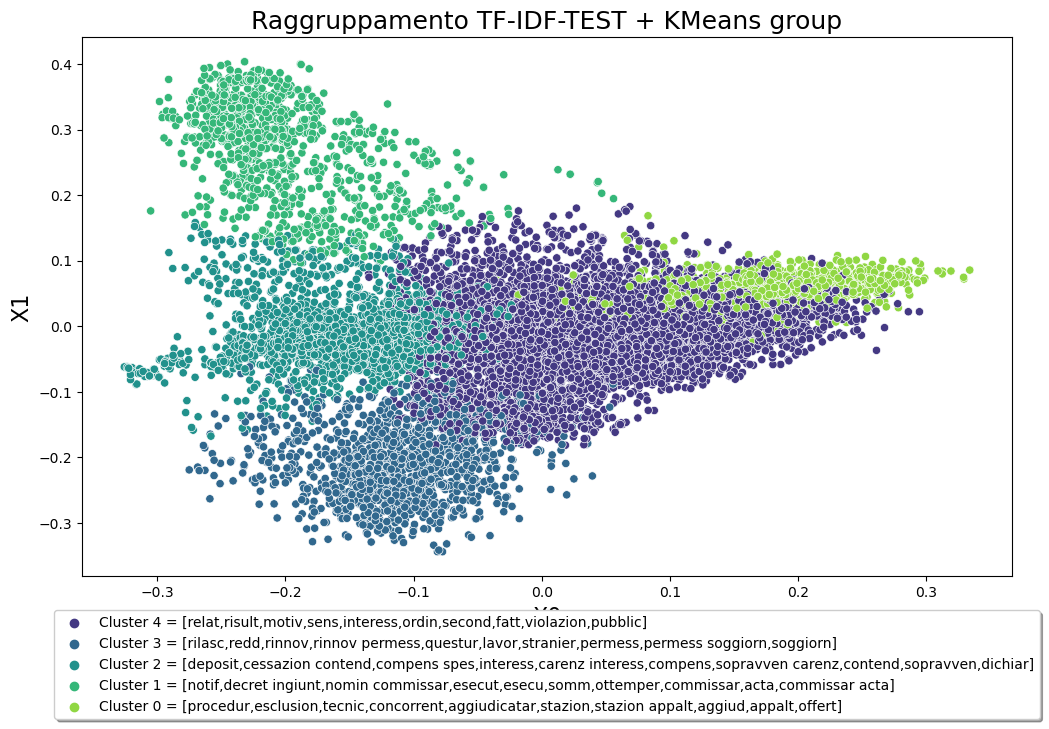

In [28]:
plot_cluster(X_test,title="Raggruppamento TF-IDF-TEST + KMeans group")

---
# Correlation test
---

In [29]:
with open(path_data+"exception/"+"comuni.txt", "r") as tf:
    comuni = tf.read().split('\n')
comuni=set(list(x.lower() for x in comuni))
with open(path_data+"exception/"+"otherStopwords.txt", "r") as tfo:
    otherstopwords = tfo.read().split('\n')
otherstopwords=set(list(x.lower() for x in otherstopwords))
with open(path_data+"exception/"+"avverbi_italiani.txt", "r") as tfo:
    avverbi_italiani = tfo.read().split('\n')
avverbi_italiani=set(list(x.lower() for x in avverbi_italiani))
with open(path_data+"exception/"+"acronimi_.txt", "r") as tfo:
    acronimi = tfo.read().split('\n')
acronimi=list(x.lower() for x in acronimi)
acronimi=set(list(''.join(filter(lambda x: x not in ['.',' ',',','!','?','#','\\','/','^','\'','\s','\n','\t'], w)) for w in acronimi))
with open(path_data+"exception/"+"codifiche_accenti.txt", "r") as tfo:
    codifiche_accenti = tfo.read().split('\n')
codifiche_accenti=set(list(x.lower() for x in codifiche_accenti))

for _,_,files in os.walk(path_data+"exception/"):
    for file in files:
        if not file in ['acronimi_.txt','avverbi_italiani.txt','codifiche_accenti.txt','comuni.txt','otherStopwords.txt']: 
            print(f"Ci troviamo nella cartella: '{file}'")
            with open(path_data+"exception/"+file, "r") as tfo:
                otherstopwords_plus = tfo.read().split('\n')
            otherstopwords=set(list(otherstopwords+otherstopwords_plus))

# stopwords list
stop_words = set(stopwords.words('italian'))
stemmer = SnowballStemmer("italian")
nomi_person= set(w.lower() for w in names.words('male.txt')+names.words('female.txt'))

eccezioni=set(comuni.union(stop_words.union(codifiche_accenti.union(otherstopwords.union(nomi_person.union(avverbi_italiani.union(acronimi)))))))


testo_x_test=testi[0]

In [30]:
def preprocessing_single_text(t):
    #LOWER_CASE
    testo= str(t).lower()

    # tokenization
    word_tokens = nltk.word_tokenize(testo);

    # Rimuovi punteggiatura
    word_tokens = list(filter(lambda token: token not in string.punctuation, word_tokens))

    # stoppping and stemming
    filtered_sentence = [re.sub(r'[0-9]+', '',stemmer.stem(''.join(filter(lambda x: x not in ['.',' ',',','-','!','?','#','\\','/','^','\'','\s','\n','\t'], w)))) 
                        for w in word_tokens if (not w in eccezioni) 
                        and (len(stemmer.stem(w))>3) ]
    filtered_sentence= [w for w in filtered_sentence if (not w in eccezioni) and (len(w)>3)]

    document = ' '.join(filtered_sentence)

    return document

preprocessing_single_text(testo_x_test)

'luogotenent arma carabinier impugn richiest sospension sanzion sospension disciplin impieg commin aver milit ricev avvis garanz concors estorsion metod mafios omess intervent appur estors dann imprenditor ricors lament violazion second capovers fattispec andrebb sussunt residu ipotes pregiudizial penal violazion termin proced disciplin eccess istruttor violazion princip proporzionalit altres domand risarc dann natur patrimonial conseguent sanzion riduzion stipend consegut serviz pensionist natur patrimonial dann immagin amministr resist ricors sosten inapplicabilit pregiudizial penal preved fatt ademp rispett termin tupimp cautel esit attivit istruttor ordin nomissis riform concess invoc sospension udienz pubblic controvers ricors tratten decisione ricors impugn sanzionator risult fond diriment second censur assorb ulterior preved riform dallarticol agost dallarticol letter proced disciplin oggett fatt relazion qual proced lautor giudiziar avvi prosegu conclus pendenz proced penal inf

In [32]:
testo=preprocessing_single_text(testo_x_test)
X_predict=pd.DataFrame({'text':[testo]})
X_tfidf_predict = tfizer.transform(X_predict['text'])

pca_vecs_pred = pca.transform(X_tfidf_predict.toarray())
# salviamo le nostre due dimensioni in x0 e x1
x0_pred = pca_vecs_pred[:, 0]
x1_pred = pca_vecs_pred[:, 1]

start_time=time_calculate()
X_predict['cluster'] = kmeans.predict(X_tfidf_predict)
X_predict['cluster'] = X_predict['cluster'].map(cluster_map)
end_time=time_calculate(bool_t=False,start_time=start_time)

X_predict['x0'] = x0_pred
X_predict['x1'] = x1_pred
X_predict

START:  2023-10-13 00:03
END:  2023-10-13 00:03
tempo impiegato 0d:00h:00m:00s


,text,cluster,x0,x1
0,luogotenent arma carabinier impugn richiest so...,"Cluster 4 = [relat,risult,motiv,sens,interess,...",0.029751,-0.0221


In [34]:
def clear_topics(x):
    chars = '"[];\\\r\\\n\\'
    return x.translate(str.maketrans('', '', chars)).split(',')[0]
df_without_duplicates['Topics']=df_without_duplicates['Topics'].apply(clear_topics)

DS=X_train.append(X_test).sort_index()
DS["Topics"]=df_without_duplicates["Topics"]
DS = DS[DS['cluster'] == X_predict['cluster'][0]]
X_tfidf_DS = tfizer.transform(DS['text'])

simil=[]
for text in X_tfidf_DS:
  try:
    simil.append(cosine_similarity(X_tfidf_predict[0] , text))
  except:
    print("errore di calcolo per 1 riga")
    simil.append([[0]])

DS["simil"]=simil
def val(x):
    return round(x[0][0],2)
DS["simil"]=DS["simil"].apply(val)
DS.head(2)

,text,cluster,x0,x1,Topics,simil
0,luogotenent arma carabinier impugn richiest so...,"Cluster 4 = [relat,risult,motiv,sens,interess,...",0.029751,-0.022100,Procedimento amministrativo,1.00
3,societ ricorrent present suap esecu lavor adeg...,"Cluster 4 = [relat,risult,motiv,sens,interess,...",0.117520,-0.021553,Enti locali,0.12


In [35]:
DS[DS['simil'] >= 0.90]

,text,cluster,x0,x1,Topics,simil
0,luogotenent arma carabinier impugn richiest so...,"Cluster 4 = [relat,risult,motiv,sens,interess,...",0.029751,-0.0221,Procedimento amministrativo,1.0


---
# Analisi richiesta da Michele

cluster
Cluster 0 = [procedur,esclusion,tecnic,concorrent,aggiudicatar,stazion,stazion appalt,aggiud,appalt,offert]                         [Ambiente, Risarcimento del danno, Contratti p...
Cluster 1 = [notif,decret ingiunt,nomin commissar,esecut,esecu,somm,ottemper,commissar,acta,commissar acta]                         [Risarcimento del danno, Sospensione Concessio...
Cluster 2 = [deposit,cessazion contend,compens spes,interess,carenz interess,compens,sopravven carenz,contend,sopravven,dichiar]    [Sospensione Concessione, Ambiente, Procedimen...
Cluster 3 = [rilasc,redd,rinnov,rinnov permess,questur,lavor,stranier,permess,permess soggiorn,soggiorn]                            [Immigrazione, Polizia amministrativa, Cittadi...
Cluster 4 = [relat,risult,motiv,sens,interess,ordin,second,fatt,violazion,pubblic]                                                  [Procedimento amministrativo, Enti locali, Edi...
Name: Topics, dtype: object
{'Accesso ai documenti amministrativi', 'Risarcimento 

<Figure size 2000x1000 with 0 Axes>

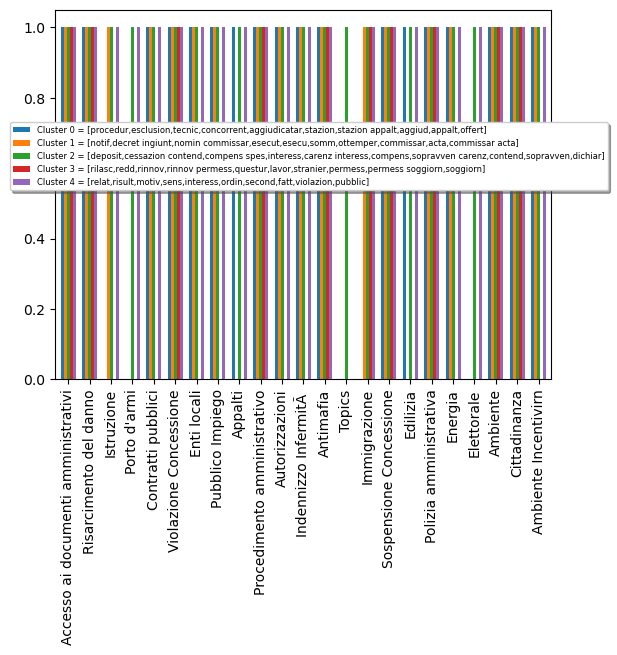

In [36]:
DSX=X_train.append(X_test).sort_index()
DSX["Topics"]=df_without_duplicates["Topics"]
s=DSX.groupby("cluster")['Topics'].unique()
print(s)
l=[]
for gr in s:
    for ss in gr:
       l.append(ss)
print(set(l))

len(s[0])==len(s[1])==len(s[2])==len(s[3])==len(s[4])

res={}
target=set(l)

for k in range (len(s)):
    res[s.keys()[k]]=dict.fromkeys(target,0)
    for t in  s[k]:
        res[s.keys()[k]][t]=res[s.keys()[k]][t]+1

# set width of bar 
data = res
fig = plt.figure(figsize=(20,10))
r={}
coll=list(data.keys())      
for i in range (n_cluster):
        print(list(data[coll[i]].values()))
        r[coll[i]]=list(data[coll[i]].values())
df_PLOT = pd.DataFrame(r, index=list(data[list(data.keys())[0]].keys()))


pltq=df_PLOT.plot(kind="bar",width=0.7)
plt.legend(fontsize=6,loc='lower left', bbox_to_anchor=(-0.1, 0.5),
          fancybox=True, shadow=True)
plt.show()